In [7]:
import numpy as np 
import pandas as pd 
import scipy.integrate

In [8]:

def load_constants():
    """Returns constants frequently used in this work"""
    params = {'vtl_max': 20,  # Max translation speed in AA/s
              'm_Rb': 7459,  # Proteinaceous mass of ribosome  in AA
              'Kd_cpc': 0.03,  # precursor dissociation constant in abundance units
              'Km': 5E-4,  # Nutrient monod constant in M
              'Y': 2.95E19,  # Yield coefficient
              'OD_conv': 1.5E17,  # Conversion factor from OD to AA mass.
              'Km_u': 3E-5,  # uncharged tRNA dissociation constant in abundance units
              'Kd_c': 3E-5,  # Charged tRNA dissociation constant in abundance units
              # Maximum tRNA synthesis rate  in abundance units per unit time
              'kappa_max': (64 * 5 * 3600) / 1E9,
              'tau': 1,  # ppGpp threshold parameter for charged/uncharged tRNA balance
              # Fraction of proteome deoveted to `other` proteins for E. coli.
              'phi_O': 0.55,
              }
    params['gamma_max'] = params['vtl_max'] * 3600 / params['m_Rb']
    return params

In [9]:
def unpack_params(params, args): 
    n_nuts = len(args['n_nutrients'])
    n_species = len(args(['n_species']))
    n_params = n_nuts + 4 # 4 is hard coded to account for M_O, M_Rb, tRNA_u, tRNA_c

    # Unpack the nutrient concentrations
    nutrients = [c for c in params[-n_nuts:]]
    masses = params[:-n_nuts]

    # Separate the params into species
    species = []
    for i in range(n_species):
        species.append(masses[i*n_params:n_params * (i + 1)])

    return nutrients, species

def compute_FPM(tRNA_u, tRNA_c, c_nt, args):
    n_nuts = len(c_nt)
    # Set ribosomal allocation, based on the ratio and enforcing positivity
    if tRNA_u <= 0:
        phi_Rb = (1 - args['phi_O'])
    else:
        ratio = tRNA_c/tRNA_u
        phi_Rb = (1 - args['phi_O']) * (ratio / (ratio + args['tau']))

    # Set the hierarchy and metabolic allocation 
    metabolic_suballocation = [] 
    if args['alpha_mode'] == 'dynamic':
        # We assume a monod function for the suballocation
        for i in range(n_nuts - 1):
            monod_fn = c_nt[i] / (c_nt[i] + args['alpha_Km'][i])
            if i == 0:
                metabolic_suballocation[i] = monod_fn
            else:
                metabolic_suballocation[i] = (1 - np.sum(metabolic_suballocation[:i]) * monod_fn)
        metabolic_suballocation[-1] = 1 - np.sum(metabolic_suballocation)

    elif args['alpha_mode'] == 'fixed':
        metabolic_suballocation = args['alpha']

    # Compute the rates
    gamma = args['gamma_max'] * tRNA_c / (tRNA_c + args['Km_c'])
    kappa = args['kappa_max'] * phi_Rb / (1 - args['phi_O'])
    nu = np.zeros_like(c_nt) 
    for i, c in enumerate(c_nt):
        nu[i] = args['nu_max'][i] * (tRNA_u / (tRNA_u + args['Km_u'])) * (c_nt[i] / (c_nt[i] + args['Km'][i])) 
 
    # Compute the net metabolic allocation
    phi_Mb = (1 - args['phi_O'] - phi_Rb) * metabolic_suballocation
    return phi_Rb, phi_Mb, nu, gamma, kappa

   
def compute_derivatives(masses, c_nt, args):
    """Computes the flux-parity system for a single community member""" 
    n_nuts = len(c_nt)
    M = np.sum(masses[:-2])

    # Unpack the metabolic masses
    M_Mb = masses[:n_nuts]

    # Unpack the ribosomal masse and charged, uncharged tRNA concentrations
    M_Rb, _,  tRNA_u, tRNA_c = masses[n_nuts:]   

    # Compute the flux-parity properties and unpack
    phi_Rb, phi_Mb, nu, gamma, kappa = compute_FPM(tRNA_u, tRNA_c, c_nt, args)

    # Compute the fluxes
    J_Rb = M_Rb * gamma / M
    J_Mb = np.sum(nu * M_Mb) / M

    # Compute the derivatives
    dM_Mb = phi_Mb * J_Rb
    dM_Rb = phi_Rb * J_Rb
    dM_O = args['phi_O'] * J_Rb
    dtRNA_u = kappa + J_Rb * (1 - tRNA_u) - J_Mb
    dtRNA_c = J_Mb - J_Rb * (1 + tRNA_c)
    dc_nt = -J_Mb * M/args['Y']
    return [dM_Mb, dM_Rb, dM_O, dtRNA_u, dtRNA_c], dc_nt


def ecosystem_dynamics(t, params, args):
    """Computes the dynamics of a community of self replicators"""
    ecosystem_args = args['ecosystem']
    community_args = args['community']
    nutrients, species = unpack_params(params, ecosystem_args)
    mass_derivatives = []
    nutrient_derivatives = np.zeros(len(nutrients))
    for i, s in enumerate(species):
        dM, dc = compute_derivatives(s, nutrients, community_args[i])
        for m in dM:
            mass_derivatives.append(m)
        for i, c in enumerate(dc):
            nutrient_derivatives[i] += c
    du = np.array([np.array(mass_derivatives), nutrient_derivatives]).flatten()     
    return du


class Ecosystem():
    def __init__(self, n_species, n_nutrients):
        self.n_species = n_species
        self.n_nutrients = n_nutrients



In [10]:
Ecosystem(4, 2)

In [21]:
class FluxParityAllocator():
    """Base class for a self replicator obeying flux-parity allocation."""
    def __init__(self, suballocation, constants={}, label=0):
        """
        Instantiates a self replicating organism that undergoes flux-parity regulation 
        of its resource allocation. 

        Parameters
        ----------
        suballocation : dict 
            A dictionary defining the metabolic suballocation strategy of the 
            self replicator. Must have the following keys:
                strategy: str, `'dynamic'` or `'static'`
                    The type of suballocation. If `'dynamic'`, the suballocation
                    of each metabolic sector follows a Monod function with a 
                    Monod constant `K` and sensitivty `n`. If `'static'`,
                    suballocation is deemed to be at a fixed value, supplied
                    with key `alpha.`    
                metabolic_rates: numpy.ndarray of floats [0, inf)
                    The metabolic rate for consumption of each nutrient in units 
                    of inverse hours.
                alpha : `numpy.ndarray` of float, [0, 1]
                    The fixed suballocation of the metabolic strategy. Values 
                    must sum to `1.0`. This is only used if `strategy: 'static'` 
                    is supplied.
                K : numpy.ndarray of float [0, inf)
                    The Monod constant for the suballocation, in units of concentration.
                    This is only used if `strategy: 'dynamic'` is supplied.
                n : numpy.ndarray of int [1, inf) 
                    The sensitivity parameter of the Monod function. This is only 
                    used if `strategy: 'dynamic'` is supplied.

               
        constants : dict, optional
            A dictionary of the constant model parameters. Default values
            (described below) can be overridden by providing a key,value pair.
                gamma_max : float
                    The maximum translation rate in inverse hours. Default 
                    value is 9.65 inv. hr. 
                phi_O : float [0, 1]
                    The allocation towards all non-ribosomal and non-metabolic 
                    proteins. Default value is 0.55. 
               tau : float [0, inf)                               
                    The sensitivity parameter of the flux-parity ribosomal 
                    allocation function. Default is 1.0
               kappa_max : float [0, inf)
                    The maximum transcription rate of uncharged tRNA in 
                    mass abundance units per hour. Default is 1.15E-3 inverse hr.
               Km_u : float [0, inf)                
                    The Michaelis-Menten constant for binding of uncharged tRNA 
                    to the metabolic components in units of relative mass abundance. 
                    Default value is 3E-5.
               Km_c : float [0, inf)                
                    The Michaelis-Menten constant for binding of charged tRNA 
                    to the ribosomal components in units of relative mass abundance. 
                    Default value is 3E-5.
               Km : numpy.ndarray [0, inf)
                    The Monod constant for metabolic activity as a function of
                    the external nutrient concentration in units of concentration. 
                    Default is the same for each nutrient with 5E-6 M.
               Y : numpy.ndarray [0, inf)
                    The yield coefficient for growth on each nutrient. Default 
                    is 2.95E19 for each nutrient supplied.              

        """
        self.num_metab = len(suballocation['nu_max'])
        self.label = label
        self.extinct = False
        self._properties = False
        # Set the properties of the self replicator.
        _constants = {'gamma_max': 9.65,
                     'phi_O': 0.55,
                     'tau': 1,
                     'kappa_max':1.15E-3,
                     'Km_u': 3E-5,
                     'Km_c': 3E-5,
                     'Km': [5E-6 for _ in range(self.num_metab)],
                     'Y': [2.95E19 for _ in range(self.num_metab)],
                     'nu_max': suballocation['nu_max']}
        self._overridden_pars = {}
        for k, v in constants.items():
            _constants[k] = v
            self._overridden_pars[k] = v

        # Set attributes from the constant dictionary.
        for k, v in _constants.items():
            setattr(self, k, v)

        # Set the suballocation details
        self.strategy = suballocation['strategy']
        if self.strategy == 'static':
            if np.sum(suballocation['alpha']) != 1:
                raise ValueError(f"Suballocation parameters must sum to 1!")
            self.alpha = suballocation['alpha'] 
        elif self.strategy == 'dynamic':
            self.K = suballocation['K']
            self.n = suballocation['n']
        else:
            raise ValueError("Supplied metabolic strategy must be either `static` or `dynamic`.") 

    def __repr__(self):
        rep = f"""
=============== Self Replicator #{self.label} ================
extinct?                    : {self.extinct}
metabolic_strategy          : {self.strategy}
number of metabolic classes : {self.num_metab}
metabolic rates             : {self.nu_max}
"""
        if self.strategy == 'dynamic':
            rep += f"\tK's [M] : {self.K}"
            rep += f"\n\tn's : {self.n}"
        elif self.strategy == 'static':
            rep += f"\talpha's: {self.alpha}"
        if len(self._overridden_pars) > 0:
            rep += f"\nOverridden Default Parameters:" 
            for k, v in self._overridden_pars.items():
                rep += f"\n\t{k}: {v}"
        if self._properties:
            rep+=f"""\n
---------------------Allocation------------------------------
tRNA ratio (charged/uncharged) : {self.ratio}
gamma (translation rate)       : {self.gamma} [inv. hr.]
nu (metabolic rate)            : {self.nu} [inv. hr.]
kappa (transcription rate)     : {self.kappa} [inv. hr.]
phi_Rb (ribosomal allocation)  : {self.phi_Rb}   
phi_Mb (metabolic allocation)  : {self.phi_Mb} 
            """ 
        return rep 

    def compute_properties(self):
        """
        Computes the self replicator properties, including the allocation parameters 
        and the corresponding rates. 

        # Parameters
        # ----------
        # tRNA_c : float [0, inf)
        #     The charged tRNA concentration in relative mass abundance units.
        # tRNA_u : float[0, inf) 
        #     The uncharged tRNA concentration in relative mass abundance units.
        # nutrients : numpy.ndarray float 
        #     The concentration of the nutrients in the environment for calculation
        #     of rates. 
        """

        # Determine if the uncharged tRNA concentration is 0. If so, set the 
        # ribosomal allocation to 1 and do not compute the ratio
        if self.tRNA_u <= 0: #Include less than zero for numerical underflow
            self.phi_Rb = (1 - self.phi_O)
            self.ratio = np.inf
        else:
            self.ratio = self.tRNA_c / self.tRNA_u
            self.phi_Rb = (1 - self.phi_O) * (self.ratio / (self.ratio + self.tau))

        # Adjust the flux parity regulation on transcription
        self.kappa = self.kappa_max * self.phi_Rb / (1 - self.phi_O)

        # Set the translation rate
        self.gamma = self.gamma_max * self.tRNA_c / (self.tRNA_c + self.Km_c)
        
        # Set the metabolic rates
        self.nu  = np.zeros_like(self.nu_max)
        metab_factor = self.tRNA_u / (self.tRNA_u + self.Km_u)
        for i in range(self.num_metab):
            env_factor = self.nutrients[i] / (self.nutrients[i] + self.Km[i])
            self.nu[i] = self.nu_max[i] * env_factor * metab_factor

        # Compute the metabolic allocation
        self.phi_Mb = np.zeros(self.num_metab)
        if self.strategy == 'static':
            # Set the fixed suballocations as prescribed by the alpha parameters.
            for i in range(self.num_metab):
                self.phi_Mb[i] = (1 - self.phi_O - self.phi_Rb) * self.alpha[i] 

        elif self.strategy == 'dynamic':
            # set the suballocation based on the nutrient concentrations
            occupied_phi_Mb = 0 
            for i in range(self.num_metab):
                if i == (self.num_metab - 1):
                    # Evaluate the remaining suballocation to the final nutrient in the hierarchy.
                    self.phi_Mb[i] = (1 - self.phi_O - self.phi_Rb - occupied_phi_Mb) 
                else:
                    # Set the suballocation given the supplied monod function properties
                    numer = (self.nutrients[i] / self.K[i])**self.n[i]
                    factor = numer / (numer + 1)
                    self.phi_Mb[i] =  (1 - self.phi_O - self.phi_Rb - occupied_phi_Mb) * factor
                    occupied_phi_Mb += self.phi_Mb[i]
        self._properties = True

    def compute_derivatives(self, masses, nutrients, outflow_rate=0):
        """
        Computes the mass and concentration derivatives given the internal flux-parity 
        allocation state.

        Parameters
        ----------
        masses : numpy.ndarray float
            The masses of the protein sectors and the concentrations of the charged 
            and uncharged tRNAs. This should be in the order of the metabolic masses,
            ribosomal mass, "other" protein masses, uncharged tRNAs, and charged tRNAs

        nutrients: numpy.ndarray float 
            The concentrations of the external nutrients.

        Returns
        -------
        masses_dot : numpy.ndarray float 
            The time derivative of the masses given the self replicator dynamics.
        nutrients_dt : numpy.ndarray float
            The time derivative the nutrient concentrations consumed by a the 
            self replicator given the dynamics.    
        """

        # Unpack the variables 
        self.M_Mb = masses[:self.num_metab]
        self.M_Rb = masses[self.num_metab]
        self.M_O = masses[self.num_metab + 1]
        self.M = np.sum(masses[:self.num_metab + 2])
        self.tRNA_u = masses[self.num_metab + 2]
        self.tRNA_c = masses[self.num_metab + 3]
        self.nutrients = np.array(nutrients) * (np.array(nutrients) >= 0)

        # Evaluate the properties
        self.compute_properties()

        # Evalutate the derivatives
        dM_Rb = self.phi_Rb * self.gamma * self.M_Rb - outflow_rate * self.M_Rb
        dM_O = self.phi_O * self.gamma * self.M_Rb  - outflow_rate * self.M_O
        dM_Mb = [phi_Mb * self.gamma * self.M_Rb - outflow_rate * self.M_Mb[i] for i, phi_Mb in enumerate(self.phi_Mb)]
        dtRNA_u = self.kappa + self.gamma * self.M_Rb * (1 - self.tRNA_u) / self.M - np.sum(self.nu * self.M_Mb) / self.M - outflow_rate * self.tRNA_u
        dtRNA_c = np.sum(self.nu * self.M_Mb) / self.M - self.gamma * self.M_Rb * (1 + self.tRNA_c) / self.M - outflow_rate * self.tRNA_c
        dc_nt = -self.nu * self.M_Mb / self.Y
        masses_dt = []
        for d in dM_Mb:
            masses_dt.append(d)
        masses_dt.append(dM_Rb)
        masses_dt.append(dM_O)
        masses_dt.append(dtRNA_u)
        masses_dt.append(dtRNA_c)
        return [np.array(masses_dt), dc_nt]

In [22]:
cell = FluxParityAllocator({'strategy': 'static', 'alpha':[0.75, 0.25, 0], 'nu_max':[10, 5, 2]})
masses = [1, 0, 0, 1, 1, 1E-5, 1E-5]
nutrients = [0.001, 0.001, 0.001]


In [23]:
def integrate_ecosystem(t, params, args):

    # Determine the flow through the chemostat
    outflow = args['outflow_rate']
    inflow = args['inflow_rate']
    deg = args['degradation_rate']
    feed_conc = args['feed_conc']

    # Determine the species and nutrient concentration
    num_species = len(args['species'])
    num_params = num_species * (4 + args['num_nutrients']) 
    nutrients = params[-args['num_nutrients']:]
    if num_species > 1:
        masses = [params[i*num_params:i*num_params + 1] for i in range(num_species)]
    else:
        masses = [params[:-args['num_nutrients']]]
    derivs = []
    nutrient_derivs = np.zeros_like(nutrients)
    for i, m in enumerate(masses):
        species = args['species'][i]
        _masses, _nutrients = species.compute_derivatives(m, nutrients, outflow_rate=outflow)
        for _m in _masses:
            derivs.append(_m) 
        nutrient_derivs += _nutrients 
    
    for i, n in enumerate(nutrient_derivs):
        # Account for chemostatic change
        _n = inflow * feed_conc[i] + n - deg * nutrients[i]
        # if nutrients[i] + _n < 0:
            # _n = -nutrients[i] 
        derivs.append(_n)
    return derivs



In [25]:
suballocation = {'strategy': 'dynamic',
                'K': [1E-5, 1E-5],
                'n': [1, 1],
                'nu_max': [10, 4]}
species = FluxParityAllocator(suballocation, label=1)

ecosystem_args = {'num_nutrients': 2, 'species':[species], 
                  'inflow_rate':0, 'outflow_rate':0, 'degradation_rate':0,
                  'feed_conc':[0, 0]}
M0 = 0.1 * 1.5E17
masses = np.array([0.1 * M0, 0.1 * M0, 0.25 * M0, 0.55 * M0, 1E-5, 1E-5])
params = list(masses)
for i in range(2):
    params.append(0.01)

time_range = np.linspace(0, 30, 300)
sol = scipy.integrate.solve_ivp(integrate_ecosystem, [0, 30], params, args=(ecosystem_args,),
                                method='LSODA', t_eval=time_range)


(0.0, 5.0)

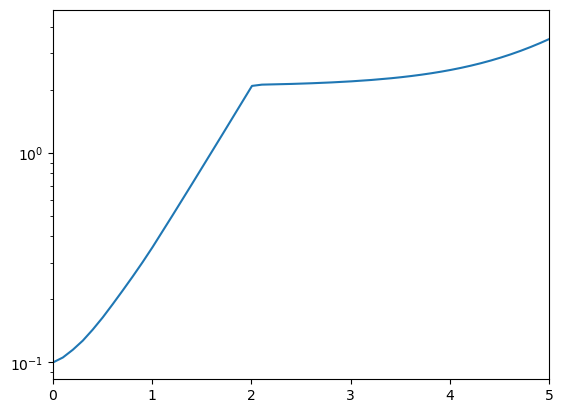

In [26]:
y = sol.y.T
M = [np.sum(y[i][:4]) for i in range(len(sol.t))]
import matplotlib.pyplot as plt
plt.semilogy(sol.t, np.array(M) / 1.5E17)
plt.xlim(0, 5)


In [ ]:
class Ecosystem():
    """Base class for an ecosystem of self-replicators"""
    def __init__(self, species, env_args):
        """
        Set up an ecosystem of J self replicators growing on K nutrients

        Parameters
        ----------
        species : list of `FluxParityAllocator`
            A list of the consitituent species of the ecosystem. Each species
            should be specified as a 
        """
